## PyTorch图像分类器

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision数据集的输出是范围在[0,1]之间的PILImage，将他们转换成归一化范围为[-1,1]之间的张量Tensor

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using downloaded and verified file: ./data\cifar-10-python.tar.gz
Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


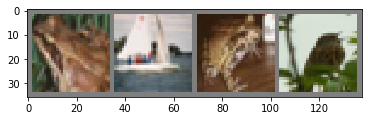

 frog  ship  frog  bird


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
    
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 定义3通道的神经网络

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
            
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Loss function: Cross-Entropy

Optimization: 动量SGD

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 训练网络

In [17]:
for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        
print('Finished Training')

[1,  2000] loss: 2.221
[1,  4000] loss: 1.910
[1,  6000] loss: 1.731
[1,  8000] loss: 1.638
[1, 10000] loss: 1.571
[1, 12000] loss: 1.512
[2,  2000] loss: 1.418
[2,  4000] loss: 1.395
[2,  6000] loss: 1.372
[2,  8000] loss: 1.330
[2, 10000] loss: 1.324
[2, 12000] loss: 1.267
Finished Training


测试网络

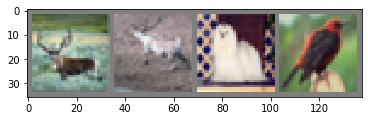

GroundTruth:   deer  deer   dog  bird
Predicted:   ship  ship   dog  bird


In [23]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
    
# GroundTruth
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(4)))
# Predicted
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(4)))

测试在整个数据集上的表现

In [28]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 53 %
Accuracy of plane : 63 %
Accuracy of   car : 78 %
Accuracy of  bird : 39 %
Accuracy of   cat : 37 %
Accuracy of  deer : 31 %
Accuracy of   dog : 44 %
Accuracy of  frog : 61 %
Accuracy of horse : 58 %
Accuracy of  ship : 77 %
Accuracy of truck : 44 %


### 转到GPU运行

In [35]:
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print(torch.cuda.get_device_name(0))

0
1
True
cuda:0
GeForce GTX 1050 Ti


In [36]:
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [37]:
for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        
print('Finished Training')

[1,  2000] loss: 2.249
[1,  4000] loss: 1.939
[1,  6000] loss: 1.717
[1,  8000] loss: 1.620
[1, 10000] loss: 1.556
[1, 12000] loss: 1.490
[2,  2000] loss: 1.437
[2,  4000] loss: 1.388
[2,  6000] loss: 1.369
[2,  8000] loss: 1.324
[2, 10000] loss: 1.338
[2, 12000] loss: 1.288
Finished Training


In [55]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 54 %
Accuracy of plane : 49 %
Accuracy of   car : 62 %
Accuracy of  bird : 37 %
Accuracy of   cat : 17 %
Accuracy of  deer : 42 %
Accuracy of   dog : 57 %
Accuracy of  frog : 79 %
Accuracy of horse : 63 %
Accuracy of  ship : 62 %
Accuracy of truck : 73 %
